# Disaster tweets EDA

In [1]:
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tqdm.notebook import tqdm

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)
sns.set_style("darkgrid")
sns.set_palette("colorblind")

target_colors = ["tab:blue", "tab:red"]

In [2]:
#!poetry add -D 'git+https://github.com/dnanhkhoa/nb_black.git@be0c810503867abc4a5e9d05ba75a16fce57dfee'
%load_ext lab_black

## Import dataset

In [3]:
dtypes = {
    "id": np.int16,
    "target": np.int8,
    "location": str,
    "keyword": str,
    "text": str,
}

df_train = pd.read_csv("./data/train.csv", dtype=dtypes)

In [4]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Missing values

- `location` has ~33% missing values.
- `keyword` has ~1% missing values.

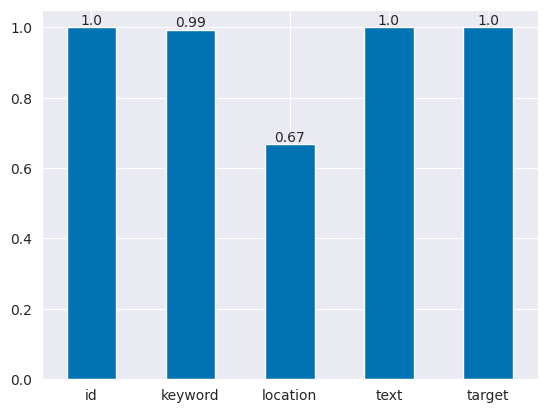

In [5]:
ax = (1 - df_train.isna().sum() / df_train.shape[0]).plot(kind="bar", rot=0)

plt.bar_label(
    container=ax.containers[0],
    labels=[np.round(val, 2) for val in ax.containers[0].datavalues],
)
plt.show()

## Target distribution

There are less tweets about real disasters.

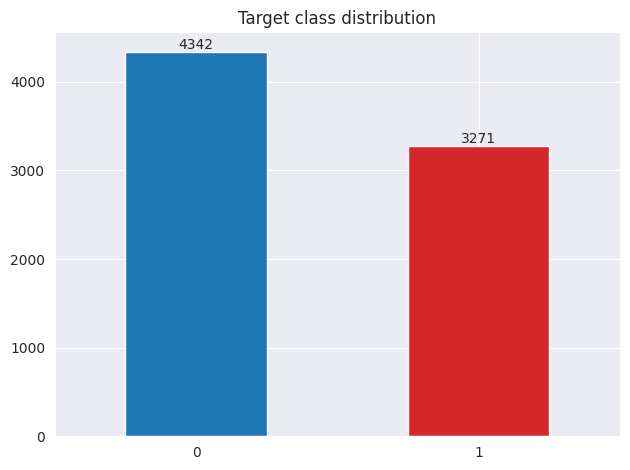

In [6]:
ax = df_train["target"].value_counts().plot.bar(rot=0, color=target_colors)

plt.title("Target class distribution")
plt.bar_label(
    ax.containers[0],
    labels=[val for val in ax.containers[0].datavalues],
)
plt.tight_layout()
plt.show()

## Preprocessing

### Extract extra informations in tweets text

In [7]:
regex_map = {
    "hashtag": r"#\w+",
    "link": r"\S*https?:\S*",
    "mention": r"@\w+",
}


def get_matches_str(text: str, pattern: str, skip: int = 1) -> str:
    """Find substrings matching a given pattern and concat them into a new string.
    If no match is found, returns 'no'.
    """
    matches = re.finditer(pattern, text)
    return " ".join([match.group(0)[skip:] for match in matches]) or "no"


def extract_tweet_infos(df: pd.DataFrame) -> pd.DataFrame:
    """d"""
    df_t = df.copy()

    for info in ["hashtag", "link", "mention"]:
        skip = 0 if info == "link" else 1
        df_t[info] = df_t["text"].apply(
            lambda x: get_matches_str(x, pattern=regex_map.get(info), skip=skip)
        )

    return df_t

### Text cleaning

In [8]:
def clean_text(text: str) -> str:
    """Apply preprocessing on text string."""
    text_lower = text.lower()
    text_no_link = re.sub(r"\S*https?:\S*", "", text_lower)
    text_no_special = re.sub(
        r"[^\w\d\s]", "", text_no_link
    )  # remove punctuation and special chars
    text_no_hashtag = re.sub(r"#", "", text_no_special)
    text_monospace = re.sub("\s+", " ", text_no_hashtag).strip()

    return text_monospace

In [9]:
example = df_train["text"][50]
print(f"Pre-cleaning {'':-<10} {example}")
print(f"Post-cleaning {'':-<10} {clean_text(example)}")

Pre-cleaning ---------- Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k
Post-cleaning ---------- deputies man shot before brighton home set ablaze


### NLP preprocessing

In [10]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

pos_map = {
    "NN": "n",
    "NNP": "n",
    "NNPS": "n",
    "NNS": "n",
    "VB": "v",
    "VBD": "v",
    "VBG": "v",
    "VBN": "v",
    "VBP": "v",
    "VBZ": "v",
    "JJ": "a",
    "JJR": "a",
    "JJS": "a",
    "RB": "r",
    "RBR": "r",
    "RBS": "r",
}


def nlp_preprocess(text: str) -> str:
    # Tokenise each word, remove stop words and tag them
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    tags = nltk.pos_tag(filtered_tokens)

    # Lemmatization
    lem_words = []
    for tag in tags:
        pos = pos_map.get(tag[1], "n")  # map word tag to lem pos
        lem_words.append(lemmatizer.lemmatize(tag[0], pos=pos))

    return " ".join(lem_words)

In [11]:
print(f"Pre-nlp {'':-<10} {clean_text(example)}")
print(f"Post-nlp {'':-<10} {nlp_preprocess(clean_text(example))}")

Pre-nlp ---------- deputies man shot before brighton home set ablaze
Post-nlp ---------- deputy man shoot brighton home set ablaze


### Preprocessing and cleaning "pipeline"

In [12]:
def preprocessing_pipeline(df: pd.DataFrame):
    """Prepare the dataset for modeling and futher analysis."""
    df_prep = df.copy()

    # Pre-cleaning
    df_prep = df_prep.drop("location", axis=1)
    df_prep["keyword"] = df_prep["keyword"].str.replace("%20", " ")

    # Feature engineering
    df_prep = extract_tweet_infos(df_prep)

    # Text cleaning
    df_prep["text"] = df_prep["text"].apply(clean_text)

    # NLP preprocessing
    df_prep["text"] = df_prep["text"].apply(nlp_preprocess)

    return df_prep


df_prep = preprocessing_pipeline(df_train)

In [13]:
df_prep.head()

,id,keyword,text,target,hashtag,link,mention
0,1,NaN,deed reason earthquake may allah forgive u,1,earthquake,no,no
1,4,NaN,forest fire near la ronge sask canada,1,no,no,no
2,5,NaN,resident ask shelter place notify officer evacuation shelter place order expect,1,no,no,no
3,6,NaN,13000 people receive wildfire evacuation order california,1,wildfires,no,no
4,7,NaN,get sent photo ruby alaska smoke wildfires pour school,1,Alaska wildfires,no,no


## Features analysis

### Keywords

Number of keywords by target class

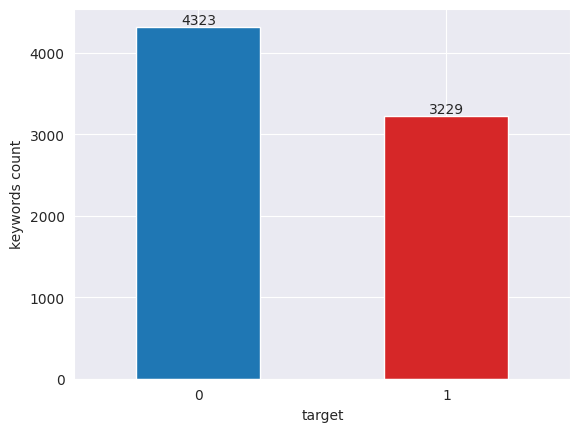

In [14]:
keywords_ct = df_prep.groupby("target")["keyword"].count()

ax = keywords_ct.plot(kind="bar", rot=0, color=target_colors)
ax.set_ylabel("keywords count")
ax.bar_label(ax.containers[0], labels=[val for val in ax.containers[0].datavalues])
plt.show()

Top keywords for each target class

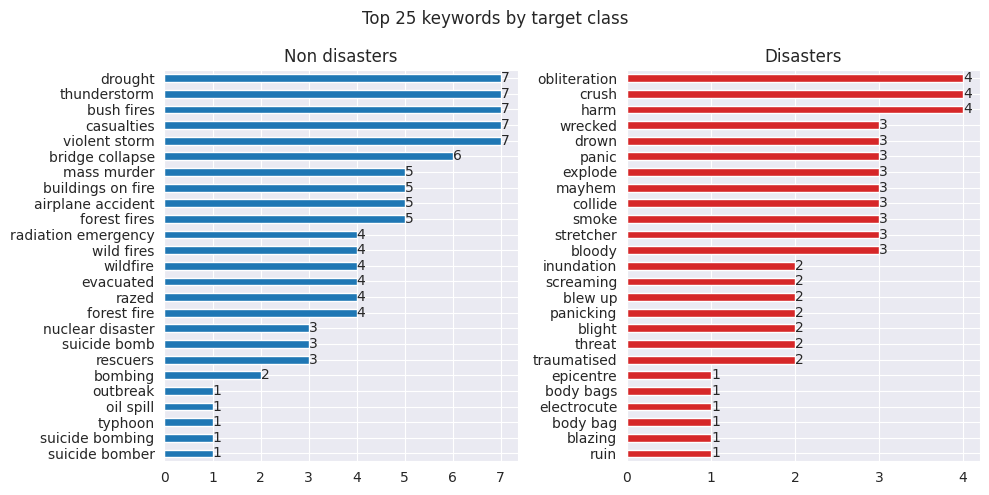

In [15]:
n = 25
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f"Top {n} keywords by target class")

for i, target in enumerate([("Non disasters", 0), ("Disasters", 1)]):
    t_title, t_class = target
    class_keywords = (
        df_prep.query(f"target == {t_class}")["keyword"]
        .value_counts(ascending=True)
        .head(n)
    )
    class_keywords.plot(kind="barh", ax=axs[i], color=target_colors[i])

    axs[i].set_title(t_title)
    axs[i].set_ylabel(None)
    axs[i].bar_label(
        axs[i].containers[0],
        labels=[val for val in axs[i].containers[0].datavalues],
    )

plt.tight_layout()
plt.show()

Measurement of keywords association with real disasters.  
The more a keyword value gets close to 1, the more it is associated to a real accident.

In [16]:
keys_conf_rate = df_prep.groupby("keyword")["target"].mean()

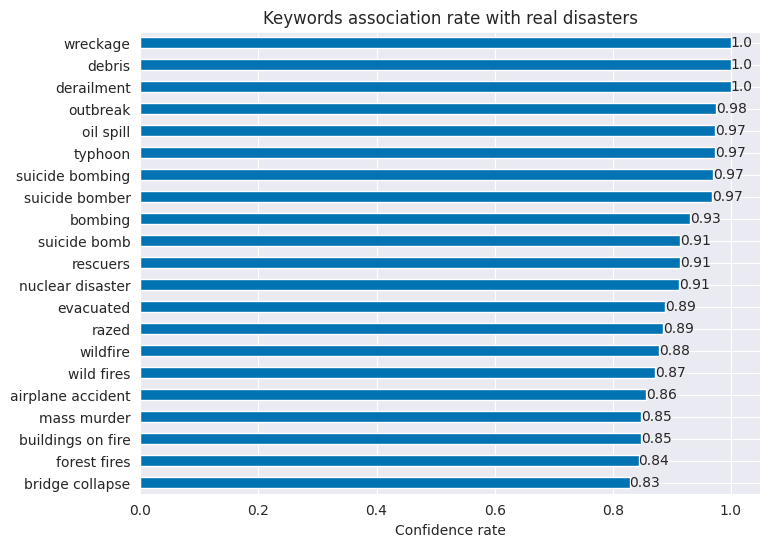

In [17]:
plt.figure(figsize=(8, 6))

ax = keys_conf_rate[keys_conf_rate > 0.8].sort_values().plot(kind="barh")

plt.title("Keywords association rate with real disasters")
plt.ylabel(None)
plt.xlabel("Confidence rate")
plt.bar_label(
    ax.containers[0],
    labels=[np.round(val, 2) for val in ax.containers[0].datavalues],
)
plt.show()

In [18]:
# df_train = df_train.merge(
#     keys_confidence.reset_index().rename({"target": "keyword_confidence"}, axis=1),
#     how="left",
#     on="keyword",
# )

### Tweet extra informations : hashtags, mentions, links

Not that many tweets have a hashtag and/or a mention.  
More than 50% of tweets have at least 1 link.

In [19]:
for info in ["hashtag", "link", "mention"]:
    query = df_prep.query(f'{info} == "no"')
    print(f"No {info + ' ':-<13} {query.shape[0] / df_prep.shape[0]}")

No hashtag ----- 0.7710495205569421
No link -------- 0.4783922238276632
No mention ----- 0.7361092867463549


Relation with target

## Apply sentiment analysis models

### VADER model

In [20]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

In [21]:
def get_vaders_scores(df: pd.DataFrame) -> pd.DataFrame:
    """Compute VADERS sentiment analysis polarity scores for each row."""
    df_vaders = df.copy()
    vaders = []

    for i, row in tqdm(df_vaders.iterrows(), total=len(df_vaders)):
        vader = sia.polarity_scores(row["text"])
        vader["id"] = row["id"]
        vaders.append(vader)

    return df_vaders.merge(pd.DataFrame.from_dict(vaders), how="left", on="id")


df_vaders = get_vaders_scores(df_prep)

  0%|          | 0/7613 [00:00<?, ?it/s]

In [22]:
df_vaders.head()

,id,keyword,text,target,hashtag,link,mention,neg,neu,pos,compound
0,1,NaN,deed reason earthquake may allah forgive u,1,earthquake,no,no,0.000,0.704,0.296,0.2732
1,4,NaN,forest fire near la ronge sask canada,1,no,no,no,0.286,0.714,0.000,-0.3400
2,5,NaN,resident ask shelter place notify officer evacuation shelter place order expect,1,no,no,no,0.000,1.000,0.000,0.0000
3,6,NaN,13000 people receive wildfire evacuation order california,1,wildfires,no,no,0.000,1.000,0.000,0.0000
4,7,NaN,get sent photo ruby alaska smoke wildfires pour school,1,Alaska wildfires,no,no,0.000,1.000,0.000,0.0000


Sentiment scores show plausible results :
- real disasters mainly seen as negative
- false disasters mainly seen as postive
- a high neutrality score for each class

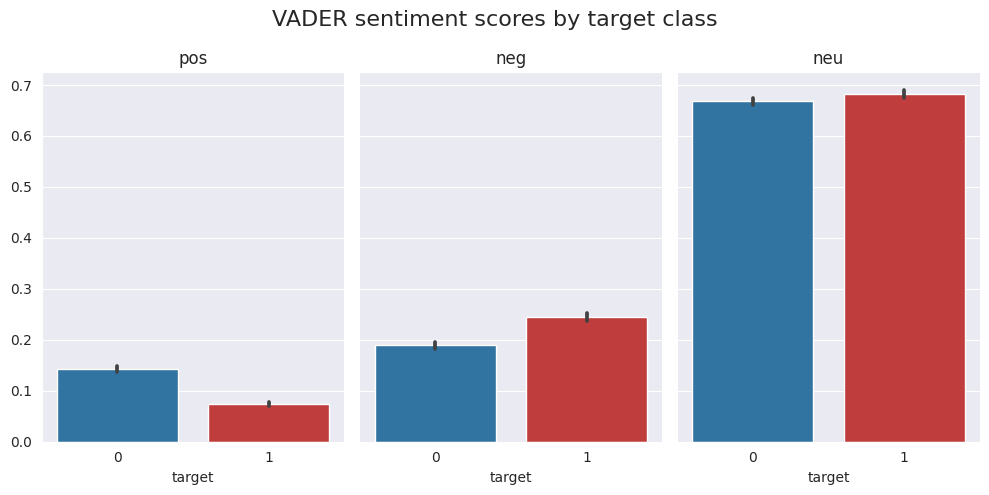

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
fig.suptitle("VADER sentiment scores by target class", fontsize=16)

for i, score in enumerate(["pos", "neg", "neu"]):
    sns.barplot(df_vaders, x="target", y=score, ax=axs[i], palette=target_colors)
    axs[i].set_title(score)
    axs[i].set_ylabel(None)

plt.tight_layout()
plt.show()

We would expect a low compound value for real disasters, as it is supposed to represent negative events.  
It is pretty much the case in average.

However, VADER doesn't recognize language subtilities as irony.  
Plus certain real disaster tweets might use informal speech, which can be seen as neutral by the model.

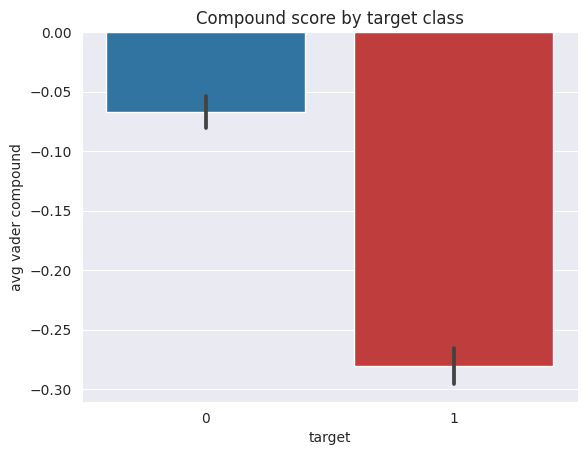

In [26]:
sns.barplot(df_vaders, x="target", y="compound", palette=target_colors)

plt.title("Compound score by target class")
plt.ylabel("avg vader compound")
plt.show()

### RoBERTa model